In [1]:
import gym
import pybullet_envs
import pybullet_envs.bullet as bul
import numpy as np
import torch
from sac_agent import soft_actor_critic_agent, device
from replay_memory import ReplayMemory

seed=0  
## env = gym.make('MinitaurBulletEnv-v0')
env = gym.make('MinitaurBulletDuckEnv-v0')
torch.manual_seed(seed)
np.random.seed(seed)
env.seed(seed)
max_steps = env._max_episode_steps
print('max_steps: ', max_steps)

batch_size=128 ##  512 
LEARNING_RATE=0.00003 
start_steps=10000 ## Steps sampling random actions
replay_size=1000000 ## size of replay buffer

agent = soft_actor_critic_agent(env.observation_space.shape[0], env.action_space, \
        hidden_size=420, seed=seed, lr=LEARNING_RATE, gamma=0.99, tau=0.005, alpha=0.2)
##        hidden_size=256, seed=seed, lr=LEARNING_RATE, gamma=0.99, tau=0.005, alpha=0.2)


memory = ReplayMemory(replay_size)

print('device: ', device)
print('leraning rate: ', LEARNING_RATE)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print('state_dim: ',state_dim, ', action_dim: ', action_dim)

threshold = env.spec.reward_threshold
print('threshold: ', threshold)


current_dir=/home/rafaels/ml-agents/lib/python3.7/site-packages/pybullet_envs/bullet
device:  cpu
urdf_root=/home/rafaels/ml-agents/lib/python3.7/site-packages/pybullet_data
options= 
max_steps:  1000
device:  cpu
leraning rate:  3e-05
state_dim:  28 , action_dim:  8
threshold:  5.0


In [2]:
def save(agent, directory, filename, episode, reward):
    torch.save(agent.policy.state_dict(), '%s/%s_actor_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.critic.state_dict(), '%s/%s_critic_%s_%s.pth' % (directory, filename, episode, reward))

In [3]:
import time
from  collections  import deque

def sac_train(max_steps):

    total_numsteps = 0
    updates = 0
    num_episodes = 40000
    updates=0

    time_start = time.time()
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = [] 
    num_steps_deque = deque(maxlen=100)
    avg_numm_steps_array = []
    
    for i_episode in range(num_episodes): 
        episode_reward = 0
        episode_steps = 0
        done = False
        state = env.reset()

        for step in range(max_steps):    
            if start_steps > total_numsteps:
                action = env.action_space.sample()  # Sample random action
            else:
                action = agent.select_action(state)  # Sample action from policy

            if len(memory) > batch_size:
                
                # Update parameters of all the networks
                agent.update_parameters(memory, batch_size, updates)

                updates += 1

            next_state, reward, done, _ = env.step(action) # Step
            episode_steps += 1
            total_numsteps += 1
            episode_reward += reward

            mask = 1 if episode_steps == env._max_episode_steps else float(not done)

            memory.push(state, action, reward, next_state, mask) # Append transition to memory

            state = next_state
            
            if done:
                break

        scores_deque.append(episode_reward)
        scores_array.append(episode_reward)        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        min_score = np.min(scores_deque)
        max_score = np.max(scores_deque)
        num_steps_deque.append(episode_steps)
        avg_num_steps = np.mean(num_steps_deque)
        avg_numm_steps_array.append(avg_num_steps)
        
        
        if i_episode % 500 == 0 and i_episode > 0:
            reward_round = round(episode_reward, 2)
            save(agent, 'dir_duck_lr0.00003', 'weights', str(i_episode), str(reward_round))

        s =  (int)(time.time() - time_start)
          
        if i_episode % 10 == 0 and i_episode > 0:  

            print("Ep.: {}, Tot.St.: {}, Avg.Num.St.: {:.1f}, Min-Max.Sc.: ({:.2f}, {:.2f}), Avg.Score: {:.3f}, Time: {:02}:{:02}:{:02}".\
                format(i_episode, total_numsteps, avg_num_steps, min_score, max_score, avg_score, \
                  s//3600, s%3600//60, s%60))

                    
        if (avg_score >= threshold):            
            print('Solved environment with Avg Score:  ', avg_score)
            
            break;
            
    return scores_array, avg_scores_array, avg_numm_steps_array 

scores, avg_scores, avg_numm_steps = sac_train(max_steps=max_steps)

Ep.: 10, Tot.St.: 4198, Avg.Num.St.: 381.6, Min-Max.Sc.: (-1.39, 0.02), Avg.Score: -0.564, Time: 00:02:42
Ep.: 20, Tot.St.: 7816, Avg.Num.St.: 372.2, Min-Max.Sc.: (-1.39, 0.02), Avg.Score: -0.553, Time: 00:05:05
Ep.: 30, Tot.St.: 10981, Avg.Num.St.: 354.2, Min-Max.Sc.: (-1.39, 0.02), Avg.Score: -0.527, Time: 00:07:10
Ep.: 40, Tot.St.: 13052, Avg.Num.St.: 318.3, Min-Max.Sc.: (-1.39, 0.02), Avg.Score: -0.470, Time: 00:08:35
Ep.: 50, Tot.St.: 15337, Avg.Num.St.: 300.7, Min-Max.Sc.: (-1.39, 0.02), Avg.Score: -0.440, Time: 00:10:07
Ep.: 60, Tot.St.: 16953, Avg.Num.St.: 277.9, Min-Max.Sc.: (-1.39, 0.04), Avg.Score: -0.399, Time: 00:11:12
Ep.: 70, Tot.St.: 19464, Avg.Num.St.: 274.1, Min-Max.Sc.: (-1.39, 0.04), Avg.Score: -0.403, Time: 00:12:52
Ep.: 80, Tot.St.: 22006, Avg.Num.St.: 271.7, Min-Max.Sc.: (-1.39, 0.04), Avg.Score: -0.408, Time: 00:14:34
Ep.: 90, Tot.St.: 24415, Avg.Num.St.: 268.3, Min-Max.Sc.: (-1.41, 0.04), Avg.Score: -0.415, Time: 00:16:11
Ep.: 100, Tot.St.: 27572, Avg.Num.St.: 

Ep.: 770, Tot.St.: 220032, Avg.Num.St.: 323.1, Min-Max.Sc.: (-1.64, 0.59), Avg.Score: -0.191, Time: 02:26:51
Ep.: 780, Tot.St.: 222383, Avg.Num.St.: 309.0, Min-Max.Sc.: (-1.64, 0.59), Avg.Score: -0.147, Time: 02:28:27
Ep.: 790, Tot.St.: 224814, Avg.Num.St.: 291.0, Min-Max.Sc.: (-0.85, 0.59), Avg.Score: -0.073, Time: 02:30:04
Ep.: 800, Tot.St.: 226893, Avg.Num.St.: 275.0, Min-Max.Sc.: (-0.54, 0.59), Avg.Score: -0.013, Time: 02:31:28
Ep.: 810, Tot.St.: 229439, Avg.Num.St.: 279.6, Min-Max.Sc.: (-0.54, 0.59), Avg.Score: 0.036, Time: 02:33:10
Ep.: 820, Tot.St.: 232008, Avg.Num.St.: 268.8, Min-Max.Sc.: (-0.39, 0.75), Avg.Score: 0.103, Time: 02:34:52
Ep.: 830, Tot.St.: 233821, Avg.Num.St.: 262.1, Min-Max.Sc.: (-0.39, 0.75), Avg.Score: 0.143, Time: 02:36:05
Ep.: 840, Tot.St.: 236507, Avg.Num.St.: 256.2, Min-Max.Sc.: (-0.39, 0.95), Avg.Score: 0.191, Time: 02:37:52
Ep.: 850, Tot.St.: 238703, Avg.Num.St.: 246.9, Min-Max.Sc.: (-0.11, 0.95), Avg.Score: 0.232, Time: 02:39:21
Ep.: 860, Tot.St.: 24116

Ep.: 1530, Tot.St.: 400455, Avg.Num.St.: 341.2, Min-Max.Sc.: (0.03, 2.82), Avg.Score: 1.026, Time: 04:29:44
Ep.: 1540, Tot.St.: 403741, Avg.Num.St.: 336.7, Min-Max.Sc.: (0.03, 2.82), Avg.Score: 1.040, Time: 04:32:03
Ep.: 1550, Tot.St.: 406934, Avg.Num.St.: 336.2, Min-Max.Sc.: (0.14, 2.82), Avg.Score: 1.042, Time: 04:34:18
Ep.: 1560, Tot.St.: 410933, Avg.Num.St.: 342.5, Min-Max.Sc.: (0.14, 3.25), Avg.Score: 1.049, Time: 04:37:08
Ep.: 1570, Tot.St.: 415554, Avg.Num.St.: 364.6, Min-Max.Sc.: (0.14, 3.38), Avg.Score: 1.143, Time: 04:40:24
Ep.: 1580, Tot.St.: 419026, Avg.Num.St.: 354.0, Min-Max.Sc.: (0.14, 3.38), Avg.Score: 1.123, Time: 04:42:52
Ep.: 1590, Tot.St.: 423413, Avg.Num.St.: 369.4, Min-Max.Sc.: (0.14, 3.38), Avg.Score: 1.166, Time: 04:45:59
Ep.: 1600, Tot.St.: 426830, Avg.Num.St.: 370.5, Min-Max.Sc.: (0.13, 3.38), Avg.Score: 1.190, Time: 04:48:25
Ep.: 1610, Tot.St.: 430650, Avg.Num.St.: 373.1, Min-Max.Sc.: (0.13, 3.38), Avg.Score: 1.214, Time: 04:51:08
Ep.: 1620, Tot.St.: 435419, 

Ep.: 2290, Tot.St.: 648172, Avg.Num.St.: 175.5, Min-Max.Sc.: (0.03, 3.12), Avg.Score: 1.038, Time: 07:32:25
Ep.: 2300, Tot.St.: 650032, Avg.Num.St.: 177.8, Min-Max.Sc.: (0.03, 3.12), Avg.Score: 1.047, Time: 07:33:51
Ep.: 2310, Tot.St.: 651261, Avg.Num.St.: 169.3, Min-Max.Sc.: (0.03, 3.12), Avg.Score: 0.993, Time: 07:34:48
Ep.: 2320, Tot.St.: 652853, Avg.Num.St.: 161.4, Min-Max.Sc.: (0.03, 2.88), Avg.Score: 0.959, Time: 07:36:02
Ep.: 2330, Tot.St.: 654536, Avg.Num.St.: 163.3, Min-Max.Sc.: (0.10, 2.88), Avg.Score: 0.983, Time: 07:37:19
Ep.: 2340, Tot.St.: 655678, Avg.Num.St.: 160.6, Min-Max.Sc.: (0.10, 2.88), Avg.Score: 0.952, Time: 07:38:13
Ep.: 2350, Tot.St.: 657500, Avg.Num.St.: 158.5, Min-Max.Sc.: (0.10, 2.88), Avg.Score: 0.939, Time: 07:39:37
Ep.: 2360, Tot.St.: 659332, Avg.Num.St.: 160.5, Min-Max.Sc.: (0.10, 3.55), Avg.Score: 0.943, Time: 07:41:02
Ep.: 2370, Tot.St.: 661173, Avg.Num.St.: 159.1, Min-Max.Sc.: (0.10, 3.55), Avg.Score: 0.948, Time: 07:42:27
Ep.: 2380, Tot.St.: 663091, 

Ep.: 3050, Tot.St.: 773357, Avg.Num.St.: 170.2, Min-Max.Sc.: (0.10, 3.43), Avg.Score: 1.058, Time: 09:10:35
Ep.: 3060, Tot.St.: 775102, Avg.Num.St.: 170.2, Min-Max.Sc.: (0.10, 3.43), Avg.Score: 1.067, Time: 09:11:58
Ep.: 3070, Tot.St.: 776668, Avg.Num.St.: 169.8, Min-Max.Sc.: (0.10, 3.43), Avg.Score: 1.061, Time: 09:13:13
Ep.: 3080, Tot.St.: 777650, Avg.Num.St.: 162.7, Min-Max.Sc.: (0.10, 3.43), Avg.Score: 0.999, Time: 09:14:00
Ep.: 3090, Tot.St.: 779211, Avg.Num.St.: 164.3, Min-Max.Sc.: (0.10, 3.43), Avg.Score: 1.012, Time: 09:15:15
Ep.: 3100, Tot.St.: 780563, Avg.Num.St.: 158.8, Min-Max.Sc.: (0.11, 3.43), Avg.Score: 0.973, Time: 09:16:20
Ep.: 3110, Tot.St.: 782063, Avg.Num.St.: 154.8, Min-Max.Sc.: (0.11, 3.43), Avg.Score: 0.964, Time: 09:17:31
Ep.: 3120, Tot.St.: 783317, Avg.Num.St.: 153.8, Min-Max.Sc.: (0.14, 3.43), Avg.Score: 0.952, Time: 09:18:32
Ep.: 3130, Tot.St.: 785094, Avg.Num.St.: 147.2, Min-Max.Sc.: (0.14, 3.43), Avg.Score: 0.926, Time: 09:19:56
Ep.: 3140, Tot.St.: 786907, 

Ep.: 3810, Tot.St.: 966773, Avg.Num.St.: 388.5, Min-Max.Sc.: (0.17, 5.49), Avg.Score: 2.701, Time: 11:44:28
Ep.: 3820, Tot.St.: 971079, Avg.Num.St.: 396.2, Min-Max.Sc.: (0.17, 5.49), Avg.Score: 2.722, Time: 11:47:54
Ep.: 3830, Tot.St.: 974716, Avg.Num.St.: 394.4, Min-Max.Sc.: (0.17, 5.49), Avg.Score: 2.723, Time: 11:50:48
Ep.: 3840, Tot.St.: 978868, Avg.Num.St.: 387.7, Min-Max.Sc.: (0.17, 5.62), Avg.Score: 2.748, Time: 11:54:06
Ep.: 3850, Tot.St.: 982517, Avg.Num.St.: 390.3, Min-Max.Sc.: (0.17, 5.62), Avg.Score: 2.799, Time: 11:57:00
Ep.: 3860, Tot.St.: 987055, Avg.Num.St.: 403.7, Min-Max.Sc.: (0.20, 5.62), Avg.Score: 2.890, Time: 12:00:35
Ep.: 3870, Tot.St.: 991008, Avg.Num.St.: 406.8, Min-Max.Sc.: (0.38, 5.62), Avg.Score: 2.952, Time: 12:03:44
Ep.: 3880, Tot.St.: 996611, Avg.Num.St.: 421.5, Min-Max.Sc.: (0.38, 5.62), Avg.Score: 3.045, Time: 12:08:10
Ep.: 3890, Tot.St.: 999995, Avg.Num.St.: 416.3, Min-Max.Sc.: (0.38, 5.62), Avg.Score: 3.020, Time: 12:10:51
Ep.: 3900, Tot.St.: 1005101,

Ep.: 4570, Tot.St.: 1282713, Avg.Num.St.: 400.6, Min-Max.Sc.: (1.01, 6.58), Avg.Score: 3.241, Time: 16:26:44
Ep.: 4580, Tot.St.: 1286405, Avg.Num.St.: 398.4, Min-Max.Sc.: (0.31, 6.58), Avg.Score: 3.225, Time: 16:30:44
Ep.: 4590, Tot.St.: 1290308, Avg.Num.St.: 400.0, Min-Max.Sc.: (0.26, 6.58), Avg.Score: 3.216, Time: 16:34:59
Ep.: 4600, Tot.St.: 1293387, Avg.Num.St.: 396.2, Min-Max.Sc.: (0.26, 6.58), Avg.Score: 3.204, Time: 16:38:23
Ep.: 4610, Tot.St.: 1298627, Avg.Num.St.: 401.3, Min-Max.Sc.: (0.26, 6.90), Avg.Score: 3.272, Time: 16:44:06
Ep.: 4620, Tot.St.: 1302201, Avg.Num.St.: 398.0, Min-Max.Sc.: (0.26, 6.90), Avg.Score: 3.245, Time: 16:48:02
Ep.: 4630, Tot.St.: 1306600, Avg.Num.St.: 395.9, Min-Max.Sc.: (0.26, 6.90), Avg.Score: 3.235, Time: 16:52:52
Ep.: 4640, Tot.St.: 1310839, Avg.Num.St.: 398.8, Min-Max.Sc.: (0.16, 6.90), Avg.Score: 3.288, Time: 16:57:33
Ep.: 4650, Tot.St.: 1314684, Avg.Num.St.: 402.3, Min-Max.Sc.: (0.16, 6.90), Avg.Score: 3.281, Time: 17:01:48
Ep.: 4660, Tot.St.:

Ep.: 5330, Tot.St.: 1577192, Avg.Num.St.: 396.6, Min-Max.Sc.: (0.21, 7.11), Avg.Score: 3.133, Time: 22:19:27
Ep.: 5340, Tot.St.: 1581675, Avg.Num.St.: 401.0, Min-Max.Sc.: (0.21, 7.29), Avg.Score: 3.141, Time: 22:25:03
Ep.: 5350, Tot.St.: 1585658, Avg.Num.St.: 397.3, Min-Max.Sc.: (0.21, 9.32), Avg.Score: 3.104, Time: 22:30:02
Ep.: 5360, Tot.St.: 1590076, Avg.Num.St.: 393.6, Min-Max.Sc.: (0.21, 9.32), Avg.Score: 3.068, Time: 22:35:33
Ep.: 5370, Tot.St.: 1593932, Avg.Num.St.: 396.4, Min-Max.Sc.: (0.21, 9.32), Avg.Score: 3.107, Time: 22:40:22
Ep.: 5380, Tot.St.: 1597942, Avg.Num.St.: 391.4, Min-Max.Sc.: (0.21, 9.32), Avg.Score: 3.079, Time: 22:45:23
Ep.: 5390, Tot.St.: 1601307, Avg.Num.St.: 383.4, Min-Max.Sc.: (0.21, 9.32), Avg.Score: 3.003, Time: 22:49:35
Ep.: 5400, Tot.St.: 1606340, Avg.Num.St.: 395.7, Min-Max.Sc.: (0.21, 9.32), Avg.Score: 3.087, Time: 22:55:52
Ep.: 5410, Tot.St.: 1609058, Avg.Num.St.: 386.6, Min-Max.Sc.: (0.21, 9.32), Avg.Score: 3.042, Time: 22:59:16
Ep.: 5420, Tot.St.:

Ep.: 6090, Tot.St.: 1876501, Avg.Num.St.: 342.1, Min-Max.Sc.: (0.22, 5.94), Avg.Score: 3.035, Time: 28:41:21
Ep.: 6100, Tot.St.: 1880445, Avg.Num.St.: 347.3, Min-Max.Sc.: (0.22, 5.94), Avg.Score: 3.085, Time: 28:46:32
Ep.: 6110, Tot.St.: 1884238, Avg.Num.St.: 347.0, Min-Max.Sc.: (0.22, 5.94), Avg.Score: 3.103, Time: 28:51:31
Ep.: 6120, Tot.St.: 1887142, Avg.Num.St.: 348.1, Min-Max.Sc.: (0.22, 5.94), Avg.Score: 3.140, Time: 28:55:20
Ep.: 6130, Tot.St.: 1890429, Avg.Num.St.: 342.2, Min-Max.Sc.: (0.22, 5.94), Avg.Score: 3.064, Time: 28:59:40
Ep.: 6140, Tot.St.: 1893126, Avg.Num.St.: 333.5, Min-Max.Sc.: (0.22, 5.94), Avg.Score: 2.985, Time: 29:03:13
Ep.: 6150, Tot.St.: 1896855, Avg.Num.St.: 334.1, Min-Max.Sc.: (0.22, 7.12), Avg.Score: 2.954, Time: 29:08:08
Ep.: 6160, Tot.St.: 1901475, Avg.Num.St.: 353.4, Min-Max.Sc.: (0.24, 7.39), Avg.Score: 3.157, Time: 29:14:15
Ep.: 6170, Tot.St.: 1905822, Avg.Num.St.: 365.7, Min-Max.Sc.: (0.30, 7.39), Avg.Score: 3.284, Time: 29:20:01
Ep.: 6180, Tot.St.:

Ep.: 6850, Tot.St.: 2138465, Avg.Num.St.: 368.3, Min-Max.Sc.: (0.34, 8.44), Avg.Score: 3.412, Time: 34:28:01
Ep.: 6860, Tot.St.: 2142092, Avg.Num.St.: 362.5, Min-Max.Sc.: (0.34, 8.44), Avg.Score: 3.355, Time: 34:32:49
Ep.: 6870, Tot.St.: 2145557, Avg.Num.St.: 361.4, Min-Max.Sc.: (0.34, 8.44), Avg.Score: 3.338, Time: 34:37:25
Ep.: 6880, Tot.St.: 2148199, Avg.Num.St.: 347.8, Min-Max.Sc.: (0.27, 8.44), Avg.Score: 3.238, Time: 34:40:55
Ep.: 6890, Tot.St.: 2151359, Avg.Num.St.: 339.1, Min-Max.Sc.: (0.27, 8.44), Avg.Score: 3.168, Time: 34:45:06
Ep.: 6900, Tot.St.: 2156378, Avg.Num.St.: 358.8, Min-Max.Sc.: (0.27, 9.08), Avg.Score: 3.330, Time: 34:51:44
Ep.: 6910, Tot.St.: 2159944, Avg.Num.St.: 358.1, Min-Max.Sc.: (0.27, 9.08), Avg.Score: 3.349, Time: 34:56:28
Ep.: 6920, Tot.St.: 2163897, Avg.Num.St.: 369.4, Min-Max.Sc.: (0.27, 9.08), Avg.Score: 3.438, Time: 35:01:42
Ep.: 6930, Tot.St.: 2167241, Avg.Num.St.: 374.2, Min-Max.Sc.: (0.27, 9.08), Avg.Score: 3.522, Time: 35:06:08
Ep.: 6940, Tot.St.:

Ep.: 7610, Tot.St.: 2401171, Avg.Num.St.: 339.8, Min-Max.Sc.: (0.33, 8.32), Avg.Score: 3.116, Time: 40:18:35
Ep.: 7620, Tot.St.: 2405470, Avg.Num.St.: 351.7, Min-Max.Sc.: (0.33, 9.89), Avg.Score: 3.221, Time: 40:24:23
Ep.: 7630, Tot.St.: 2409142, Avg.Num.St.: 356.9, Min-Max.Sc.: (0.33, 9.89), Avg.Score: 3.239, Time: 40:29:20
Ep.: 7640, Tot.St.: 2413785, Avg.Num.St.: 366.1, Min-Max.Sc.: (0.33, 9.89), Avg.Score: 3.321, Time: 40:35:34
Ep.: 7650, Tot.St.: 2417349, Avg.Num.St.: 357.6, Min-Max.Sc.: (0.33, 9.89), Avg.Score: 3.285, Time: 40:40:21
Ep.: 7660, Tot.St.: 2421034, Avg.Num.St.: 354.6, Min-Max.Sc.: (0.33, 9.89), Avg.Score: 3.259, Time: 40:45:18
Ep.: 7670, Tot.St.: 2424049, Avg.Num.St.: 350.5, Min-Max.Sc.: (0.29, 9.89), Avg.Score: 3.236, Time: 40:49:20
Ep.: 7680, Tot.St.: 2427280, Avg.Num.St.: 351.8, Min-Max.Sc.: (0.29, 9.89), Avg.Score: 3.263, Time: 40:53:39
Ep.: 7690, Tot.St.: 2431794, Avg.Num.St.: 362.2, Min-Max.Sc.: (0.29, 9.89), Avg.Score: 3.324, Time: 40:59:42
Ep.: 7700, Tot.St.:

Ep.: 8360, Tot.St.: 2623024, Avg.Num.St.: 316.4, Min-Max.Sc.: (0.26, 10.79), Avg.Score: 3.058, Time: 45:17:14
Ep.: 8370, Tot.St.: 2626245, Avg.Num.St.: 312.3, Min-Max.Sc.: (0.26, 10.79), Avg.Score: 3.050, Time: 45:21:34
Ep.: 8380, Tot.St.: 2629641, Avg.Num.St.: 323.0, Min-Max.Sc.: (0.26, 10.79), Avg.Score: 3.141, Time: 45:26:09
Ep.: 8390, Tot.St.: 2632229, Avg.Num.St.: 326.6, Min-Max.Sc.: (0.30, 10.79), Avg.Score: 3.176, Time: 45:29:38
Ep.: 8400, Tot.St.: 2635056, Avg.Num.St.: 319.7, Min-Max.Sc.: (0.30, 10.79), Avg.Score: 3.140, Time: 45:33:27
Ep.: 8410, Tot.St.: 2637881, Avg.Num.St.: 323.3, Min-Max.Sc.: (0.31, 10.79), Avg.Score: 3.203, Time: 45:37:17
Ep.: 8420, Tot.St.: 2641690, Avg.Num.St.: 330.8, Min-Max.Sc.: (0.31, 10.79), Avg.Score: 3.264, Time: 45:42:26
Ep.: 8430, Tot.St.: 2644688, Avg.Num.St.: 322.2, Min-Max.Sc.: (0.31, 10.79), Avg.Score: 3.184, Time: 45:46:30
Ep.: 8440, Tot.St.: 2648581, Avg.Num.St.: 317.7, Min-Max.Sc.: (0.30, 10.44), Avg.Score: 3.083, Time: 45:51:47
Ep.: 8450,

Ep.: 9120, Tot.St.: 2830125, Avg.Num.St.: 264.6, Min-Max.Sc.: (0.26, 9.20), Avg.Score: 2.560, Time: 49:59:29
Ep.: 9130, Tot.St.: 2833422, Avg.Num.St.: 273.2, Min-Max.Sc.: (0.26, 9.20), Avg.Score: 2.638, Time: 50:03:57
Ep.: 9140, Tot.St.: 2836320, Avg.Num.St.: 264.9, Min-Max.Sc.: (0.26, 9.20), Avg.Score: 2.565, Time: 50:07:53
Ep.: 9150, Tot.St.: 2839280, Avg.Num.St.: 266.8, Min-Max.Sc.: (0.26, 10.29), Avg.Score: 2.601, Time: 50:11:55
Ep.: 9160, Tot.St.: 2841424, Avg.Num.St.: 262.0, Min-Max.Sc.: (0.26, 10.29), Avg.Score: 2.561, Time: 50:14:49
Ep.: 9170, Tot.St.: 2844738, Avg.Num.St.: 272.9, Min-Max.Sc.: (0.26, 10.29), Avg.Score: 2.638, Time: 50:19:20
Ep.: 9180, Tot.St.: 2847958, Avg.Num.St.: 274.2, Min-Max.Sc.: (0.26, 10.29), Avg.Score: 2.643, Time: 50:23:44
Ep.: 9190, Tot.St.: 2850194, Avg.Num.St.: 277.3, Min-Max.Sc.: (0.26, 10.29), Avg.Score: 2.688, Time: 50:26:46
Ep.: 9200, Tot.St.: 2852224, Avg.Num.St.: 272.3, Min-Max.Sc.: (0.26, 10.29), Avg.Score: 2.641, Time: 50:29:33
Ep.: 9210, To

Ep.: 9870, Tot.St.: 3029176, Avg.Num.St.: 280.9, Min-Max.Sc.: (0.31, 10.89), Avg.Score: 2.867, Time: 54:30:41
Ep.: 9880, Tot.St.: 3031874, Avg.Num.St.: 283.9, Min-Max.Sc.: (0.31, 10.89), Avg.Score: 2.876, Time: 54:34:22
Ep.: 9890, Tot.St.: 3034547, Avg.Num.St.: 271.6, Min-Max.Sc.: (0.31, 7.65), Avg.Score: 2.724, Time: 54:38:01
Ep.: 9900, Tot.St.: 3037007, Avg.Num.St.: 274.7, Min-Max.Sc.: (0.34, 7.65), Avg.Score: 2.748, Time: 54:41:22
Ep.: 9910, Tot.St.: 3040447, Avg.Num.St.: 274.8, Min-Max.Sc.: (0.34, 7.00), Avg.Score: 2.726, Time: 54:46:02
Ep.: 9920, Tot.St.: 3042594, Avg.Num.St.: 268.5, Min-Max.Sc.: (0.34, 7.00), Avg.Score: 2.684, Time: 54:48:58
Ep.: 9930, Tot.St.: 3045153, Avg.Num.St.: 271.7, Min-Max.Sc.: (0.34, 7.00), Avg.Score: 2.716, Time: 54:52:26
Ep.: 9940, Tot.St.: 3048027, Avg.Num.St.: 274.1, Min-Max.Sc.: (0.26, 8.24), Avg.Score: 2.731, Time: 54:56:22
Ep.: 9950, Tot.St.: 3050841, Avg.Num.St.: 278.3, Min-Max.Sc.: (0.26, 8.24), Avg.Score: 2.786, Time: 55:00:12
Ep.: 9960, Tot.St

Ep.: 10620, Tot.St.: 3235386, Avg.Num.St.: 299.1, Min-Max.Sc.: (0.93, 9.07), Avg.Score: 2.993, Time: 59:12:05
Ep.: 10630, Tot.St.: 3238307, Avg.Num.St.: 298.1, Min-Max.Sc.: (0.93, 9.07), Avg.Score: 2.982, Time: 59:16:03
Ep.: 10640, Tot.St.: 3240772, Avg.Num.St.: 289.2, Min-Max.Sc.: (0.59, 7.84), Avg.Score: 2.876, Time: 59:19:24
Ep.: 10650, Tot.St.: 3243554, Avg.Num.St.: 283.0, Min-Max.Sc.: (0.59, 6.83), Avg.Score: 2.833, Time: 59:23:11
Ep.: 10660, Tot.St.: 3246350, Avg.Num.St.: 280.5, Min-Max.Sc.: (0.40, 6.83), Avg.Score: 2.838, Time: 59:26:59
Ep.: 10670, Tot.St.: 3249290, Avg.Num.St.: 276.9, Min-Max.Sc.: (0.40, 6.83), Avg.Score: 2.790, Time: 59:31:00
Ep.: 10680, Tot.St.: 3251951, Avg.Num.St.: 275.2, Min-Max.Sc.: (0.40, 6.83), Avg.Score: 2.797, Time: 59:34:37
Ep.: 10690, Tot.St.: 3255545, Avg.Num.St.: 288.9, Min-Max.Sc.: (0.40, 6.83), Avg.Score: 2.909, Time: 59:39:31
Ep.: 10700, Tot.St.: 3259131, Avg.Num.St.: 293.8, Min-Max.Sc.: (0.33, 7.62), Avg.Score: 2.974, Time: 59:44:24
Ep.: 10710

Ep.: 11370, Tot.St.: 3442565, Avg.Num.St.: 270.7, Min-Max.Sc.: (0.26, 10.66), Avg.Score: 2.809, Time: 63:55:16
Ep.: 11380, Tot.St.: 3445030, Avg.Num.St.: 266.6, Min-Max.Sc.: (0.26, 10.66), Avg.Score: 2.763, Time: 63:58:38
Ep.: 11390, Tot.St.: 3447124, Avg.Num.St.: 254.2, Min-Max.Sc.: (0.26, 6.60), Avg.Score: 2.634, Time: 64:01:31
Ep.: 11400, Tot.St.: 3449713, Avg.Num.St.: 253.4, Min-Max.Sc.: (0.26, 6.60), Avg.Score: 2.657, Time: 64:05:04
Ep.: 11410, Tot.St.: 3451834, Avg.Num.St.: 247.9, Min-Max.Sc.: (0.26, 6.60), Avg.Score: 2.598, Time: 64:07:59
Ep.: 11420, Tot.St.: 3454418, Avg.Num.St.: 247.2, Min-Max.Sc.: (0.26, 6.60), Avg.Score: 2.615, Time: 64:11:31
Ep.: 11430, Tot.St.: 3456894, Avg.Num.St.: 243.3, Min-Max.Sc.: (0.26, 5.68), Avg.Score: 2.564, Time: 64:14:55
Ep.: 11440, Tot.St.: 3460000, Avg.Num.St.: 249.3, Min-Max.Sc.: (0.26, 9.95), Avg.Score: 2.629, Time: 64:19:10
Ep.: 11450, Tot.St.: 3462864, Avg.Num.St.: 254.4, Min-Max.Sc.: (0.29, 9.95), Avg.Score: 2.674, Time: 64:23:05
Ep.: 114

Ep.: 12120, Tot.St.: 3662678, Avg.Num.St.: 305.4, Min-Max.Sc.: (0.93, 10.82), Avg.Score: 3.348, Time: 68:57:10
Ep.: 12130, Tot.St.: 3666646, Avg.Num.St.: 317.0, Min-Max.Sc.: (0.93, 10.82), Avg.Score: 3.497, Time: 69:02:37
Ep.: 12140, Tot.St.: 3669716, Avg.Num.St.: 306.4, Min-Max.Sc.: (0.29, 9.81), Avg.Score: 3.434, Time: 69:06:51
Ep.: 12150, Tot.St.: 3673013, Avg.Num.St.: 313.4, Min-Max.Sc.: (0.29, 9.81), Avg.Score: 3.499, Time: 69:11:23
Ep.: 12160, Tot.St.: 3677183, Avg.Num.St.: 322.5, Min-Max.Sc.: (0.29, 11.93), Avg.Score: 3.532, Time: 69:17:06
Ep.: 12170, Tot.St.: 3680176, Avg.Num.St.: 324.7, Min-Max.Sc.: (0.29, 11.93), Avg.Score: 3.571, Time: 69:21:12
Ep.: 12180, Tot.St.: 3683134, Avg.Num.St.: 315.4, Min-Max.Sc.: (0.29, 11.93), Avg.Score: 3.490, Time: 69:25:15
Ep.: 12190, Tot.St.: 3686480, Avg.Num.St.: 323.9, Min-Max.Sc.: (0.29, 11.93), Avg.Score: 3.583, Time: 69:29:49
Ep.: 12200, Tot.St.: 3689390, Avg.Num.St.: 321.6, Min-Max.Sc.: (0.29, 11.93), Avg.Score: 3.538, Time: 69:33:50
Ep.

Ep.: 12860, Tot.St.: 3933131, Avg.Num.St.: 415.6, Min-Max.Sc.: (0.34, 12.51), Avg.Score: 4.642, Time: 75:08:51
Ep.: 12870, Tot.St.: 3938640, Avg.Num.St.: 438.9, Min-Max.Sc.: (0.34, 12.51), Avg.Score: 4.924, Time: 75:16:29
Ep.: 12880, Tot.St.: 3942984, Avg.Num.St.: 432.1, Min-Max.Sc.: (0.34, 12.51), Avg.Score: 4.845, Time: 75:22:32
Solved environment with Avg Score:   5.022619391295142


In [4]:
reward_round = round(np.max(scores), 2)
save(agent, 'dir_duck_lr0.00003', 'weights', 'final', str(reward_round))

length of scores:  12888 , len of avg_scores:  12888


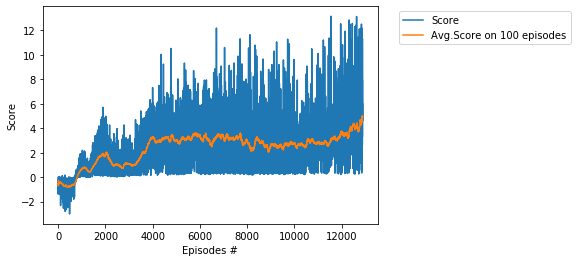

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg.Score on 100 episodes")
## plt.plot(np.arange(1, len(avg_numm_steps)+1), avg_numm_steps, label="Avg.Num.Steps on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

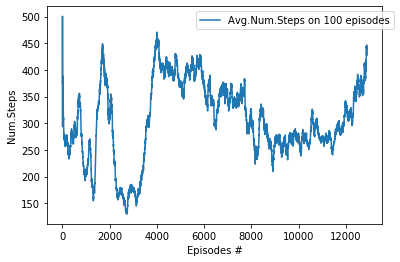

In [6]:
fig2 = plt.figure()
ax = fig2.add_subplot(111)
# plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
# plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg.Score on 100 episodes")
plt.plot(np.arange(1, len(avg_numm_steps)+1), avg_numm_steps, label="Avg.Num.Steps on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Num.Steps')
plt.xlabel('Episodes #')
plt.show()

In [ ]:
def play(env, agent, num_episodes):
    
    state = env.reset()
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(num_episodes + 1):
        
        state = env.reset()
        score = 0                    
        time_start = time.time()
        
        while True:
            
            action = agent.select_action(state, eval=False)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward 
            state = next_state
    
            if done:
                break
                
        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)    
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60)) 
    

In [ ]:
#import pybullet_envs.bullet.minitaur_gym_env as e
#env_render = e.MinitaurBulletEnv(render=True)
#play(env=env_render, agent=agent, num_episodes=5)

In [ ]:
env.close()